processing  LogisticRegression
[[1989    1]
 [ 111    0]]
processing  SVM
[[1990    0]
 [ 111    0]]
processing  NeuralNetwork
[[1990    0]
 [ 111    0]]
processing  BernoulliNaiveBayes
[[1531  459]
 [  54   57]]
processing  Extreme Gradient Boosting
[[995 995]
 [  0 111]]
processing  Light Gradient Boosting Machine
[[1378  612]
 [   0  111]]
                   Classifier Name  ...  Train Accuracy Score
0               LogisticRegression  ...              0.954059
1                              SVM  ...              1.000000
2                    NeuralNetwork  ...              0.954297
3              BernoulliNaiveBayes  ...              0.765413
4        Extreme Gradient Boosting  ...              1.000000
5  Light Gradient Boosting Machine  ...              1.000000

[6 rows x 4 columns]


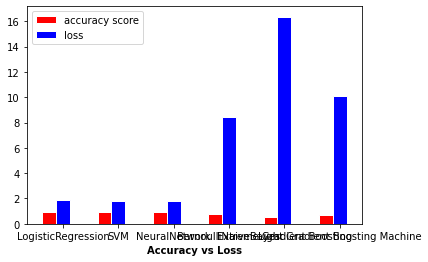

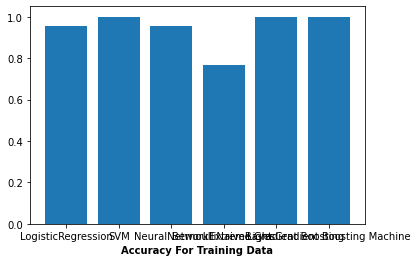

In [ ]:
import warnings

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import log_loss
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix

warnings.filterwarnings('ignore')


def plot_histogram(accuracy_scores, losses, classifier_names):
    """
    Used for plotting performance of various classification models wrt accuracy score and losses.
    :param accuracy_scores: Accuracy score of predicting models.
    :param losses: Log Loss for Classification model used for prediction.
    :param classifier_names: Name of the classifier used.
    :return: Does not return anything.
    """

    bar_width = 0.25

    fig, ax = plt.subplots()
    # Set position of bar on X axis
    r1 = np.arange(len(accuracy_scores))
    r2 = [x + bar_width for x in r1]

    # Make the plot
    plt.bar(r1, accuracy_scores, color='red', width=bar_width, edgecolor='white', label='accuracy score')
    plt.bar(r2, losses, color='blue', width=bar_width, edgecolor='white', label='loss')

    # Add xticks on the middle of the group bars
    plt.xlabel('Accuracy vs Loss', fontweight='bold')
    plt.xticks([r + bar_width for r in range(len(accuracy_scores))], classifier_names)

    # Create legend
    plt.legend()
    return plt


def plot(accuracy_score, classifier_names):
    """
    Used for plotting performance of various classification models during training for accuracy to indicate over-fitting
    :param accuracy_score: Accuracy score of predicting models during training.
    :param classifier_names: Name of the classifier used.
    :return: plot
    """
    x = np.arange(len(accuracy_score))
    fig, ax = plt.subplots()
    plt.bar(x, accuracy_score)
    plt.xlabel('Accuracy For Training Data', fontweight='bold')
    plt.xticks(x, classifier_names)

    return plt

def main():
    """
    Load and scale data, runs various classification models and evaluate the performance of each.
    :return:
    """

    # Create a pipeline to fill empty values and scale to unit variance. Done to avoid issues running models.
    pipe = Pipeline([
        ("impute", SimpleImputer(missing_values=np.nan, strategy='mean'))
        #("scaler", StandardScaler()),
    ])

    # Load Training and Test Data which was pre-curated. check src/data on how data was curated.
    train = pd.read_csv("/content/train.csv")
    test = pd.read_csv("/content/test.csv")

    # Run pipeline to fill and scale data.
    x_train = pipe.fit_transform(train.drop('class', axis=1))
    x_test = pipe.transform(test.drop('class', axis=1))

    # Extract y column.
    y_train = train['class']
    y_test = test['class']

    # Initialize all the classifier that we are going to run.
    classifier = [
        LogisticRegression(),
        SVC(gamma='auto'),
        MLPClassifier(solver='sgd', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1),
        BernoulliNB(),
        XGBClassifier(),
        lgb.LGBMClassifier()
    ]

    # Names of all the classifiers.
    classifier_name = [
        "LogisticRegression",
        "SVM",
        "NeuralNetwork",
        "BernoulliNaiveBayes",
        "Extreme Gradient Boosting",
        "Light Gradient Boosting Machine"
    ]

    # Initialize all the collections used to keep track of performances of the model.
    test_scores = np.zeros(len(classifier))
    test_loss = np.zeros(len(classifier))

    train_scores = np.zeros(len(classifier))

    # For each classifier, Train, Predict and monitor the performance.
    model_performance_metric_plots = None
    for i in np.arange(len(classifier)):
        print("processing ", classifier_name[i])
        classifier[i].fit(x_train, y_train)
        train_scores[i] = classifier[i].score(x_train, y_train)

        y_pred = classifier[i].predict(x_test)
        test_scores[i] = classifier[i].score(x_test, y_test)
        test_loss[i] = log_loss(y_test, y_pred)

        print(confusion_matrix(y_test, y_pred))

        # Evaluated models and Plot.
        #model_performance_metric_plots = plot_learning_curve(classifier[i], x_train, y_train, classifier_name[i])

    # Plot the performance using the metrics collected.
    model_histograms = plot_histogram(test_scores, test_loss, classifier_name)
    model_score = plot(train_scores, classifier_name)

    # Print the performance metrics.
    print(pd.DataFrame({"Classifier Name": classifier_name,
                        "Test Accuracy Score": test_scores,
                        "Test Log Loss": test_loss,
                        "Train Accuracy Score": train_scores}))
    #model_performance_metric_plots.show()
    model_histograms.show()
    model_score.show()


if __name__ == '__main__':
    main()
